In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pickle
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from tqdm import tqdm
import itertools
%matplotlib inline

In [2]:
df = pd.read_csv("cc_data_jobrecoded07_12.csv",dtype=str)
# We need to NOT load numbers as floats, 2000 is not the same code as 2000.0
# pandas reads in blank cells as NaN. This is useful.

In [3]:
def extract_date_cols(df):
    date_inds = []
    for i in range(len(df.columns)):
        label = df.columns[i]
        if ('s' in label or 'e' in label) and ('job' in label):
            date_inds.append(i)
    cleaned = df.drop(df.columns[date_inds],axis=1)
    date_cols = df[date_inds]
    return cleaned,date_cols

In [4]:
# Career sequences (with dates)
jobs = df.ix[:,48:]
jobs,date_cols = extract_date_cols(jobs)

In [5]:
dates = date_cols.values.flatten()
dates = [date for date in dates if date == date]
print(sorted(set(dates)))

[' ', '11972', '11978', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2012', '2013', '2507']


In [6]:
job_seqs = []

for row_index in range(1605):
    job_seq = jobs.ix[row_index:row_index].values[0]
    job_seqs.append(job_seq)
    
dates = []
for row_index in range(1605):
    years = date_cols.ix[row_index:row_index].values[0]
    date_pairs = []
    for col_index in range(0,54,2):
        t0 = years[col_index]
        t1 = years[col_index+1]
        # Check if these are Nans
        if t0!=t0 or t1!=t1:
            t0,t1=(0,0)
        else:
            t0,t1=(int(t0),int(t1))
        date_pairs.append((t0,t1))
    dates.append(date_pairs)
    
birthyears = df.birth.values

In [7]:
birthyears[674]

nan

In [8]:
earliest = 1921
latest = 2013
tdelta = latest-earliest

In [9]:
time_seqs = []
for job_seq, date_pairs in zip(job_seqs,dates):
    time_seq = [[]]*tdelta
    for job, date_pair in zip(job_seq, date_pairs):
        if job == job:
            t_range = range(date_pair[0]-earliest,date_pair[1]-earliest)
            for t in t_range:
                time_seq[t] = time_seq[t] + [job]
    time_seqs.append(time_seq)

In [10]:
regions = {   'B1':['208','209','210','211','212','214'],
              'B2':['205','206','207'],
              'B3':['200','201','202','203','204'],
              'B4':['218','219','220'],
              'B5':['213','215','216','217'],
              'B6':['226','227','228','229','230'],
              'B7':['221','222','223','224','225']}

def recoder(job_code):
    if job_code != job_code: # If it is a NaN
        return 'Y'
    if float(job_code) < 100:
        return 'A1'
    if job_code[0] == '6':
        return 'A1'
    if job_code[0] == '1':
        return 'A2'
    if job_code[0] == '4':
        return 'A3'
    if job_code[0] == '5':
        return 'A4'
    if job_code[0] == '3':
        return 'C'
    if job_code[:2] == '25':
        return 'B8'
    if job_code[0] == '2':
        
        prov = job_code[:3]
        for region in regions.keys():
            if prov in regions[region]:
                return region

        print('Failed to identify region for ' + job_code)
        return 'Z'
    else:
        print("Couldn't classify " + job_code)
        return 'Z'

In [11]:
time_seqs_r = []
for time_seq in time_seqs:
    time_seq_r = []
    for jobs in time_seq:
        time_seq_r.append([recoder(job) for job in jobs])
    time_seqs_r.append(time_seq_r)

Failed to identify region for 2457
Failed to identify region for 2457
Failed to identify region for 2457
Failed to identify region for 2457


In [12]:
codes = ['A1','A2','A3','A4','B1','B2','B3','B4','B5','B6','B7','B8','C','Y','Z']
code_names = ['CCP Official/A1','Bureaucracy/A2','Congress/A3',
              'Judicial/A4',
              'Eastern/B1',
              'NorthEast/B2',
              'North/B3',
              'South/B4',
              'Central/B5',
              'NorthWest/B6',
              'SouthWest/B7',
              'Prov. CCP Head/B8',
              'Military/C',
              'Outside gov/Y',
              'Unclassified/Z']
              
graph_codes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
graph_map = dict(zip(codes,graph_codes))

In [13]:
# Convert each career trajectory to a numerical sequence
# that matplotlib can plot.
time_seqs_g = []
for time_seq in time_seqs_r:
    time_seq_g = []
    for jobs in time_seq:
        if jobs == []:
            time_seq_g.append([0])
        else:
            time_seq_g.append([graph_map[job] for job in jobs])
    time_seqs_g.append(time_seq_g)


In [14]:
# Convert to... edges? to allow plotting
pointPairs_seqs = []
for time_seq_g in time_seqs_g:
    
    pointPairs = []
    tdelta = len(time_seq_g)
    for i in range(tdelta):
        
        
        if i == tdelta-1:
            break
            
        currentJobs = time_seq_g[i]
        nextJobs = time_seq_g[i+1]
        
        for cJob in currentJobs:
            xPoint = [i,i+1]
            for nJob in nextJobs:
                yPoint = [cJob,nJob]
                pointPairs.append(xPoint)
                pointPairs.append(yPoint)
    
    
    pointPairs_seqs.append(pointPairs)


In [15]:
def plot_traj_group(traj_group,color,plotname):
    plt.figure()
    for traj in traj_group:
        plt.plot(range(len(traj)),traj,
            alpha=0.03,
            color=color,
            marker='o')

        # Set the x- and y-axis labels
    plt.xticks(np.arange(0,26,1.0))
    #plt.yticks(np.arange(1,16,1.0),codes,size=18)
    plt.yticks(np.arange(1,16,1.0),code_names,size=14)
    

    # Specifies the domain and range displayed
    plt.axis([0,25,0,15])

    #plt.gca().xaxis.grid(True)
    #plt.gca().yaxis.grid(True)

    fig = plt.gcf() # Returns the current figure instance
    fig.tight_layout()
    fig.set_size_inches(18, 7)
    fig.savefig(plotname,bbox_inches='tight')

In [16]:
print('hello')

hello


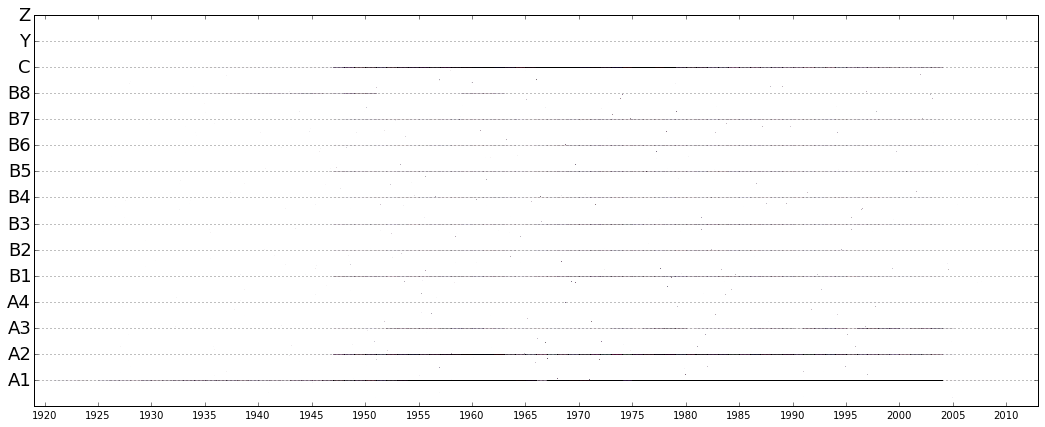

In [23]:
for pointPairs in tqdm(pointPairs_seqs):
    plt.plot(*pointPairs,alpha=0.005)
    
#plt.plot(*pointPairs_seqs[0],alpha=0.25,color='r')
#plt.plot(*pointPairs_seqs[1],alpha=0.25,color='g')
#plt.plot(*pointPairs_seqs[2],alpha=0.25,color='b')
#plt.plot(*pointPairs_seqs[3],alpha=0.25,color='m')


dates = range(1920,2013,5)
plt.xticks(np.arange(1,92,5.0),dates)
plt.yticks(np.arange(1,16,1.0),codes,size=18)
plt.axis([0,94,0,15])

plt.gca().yaxis.grid(True)



fig = plt.gcf() # Returns the current figure instance
fig.set_size_inches(18, 7)
fig.savefig('TimeSequence_entire.png',bbox_inches='tight',dpi=400)
